In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
DOF_X = 100
DOF_Y = 100
N_COLLOCATION_POINTS = 100
LEARNING_RATE = 1e-3
N_OPTIMIZATION_EPOCHS = 1000
BC_LOSS_WEIGHT = 100.0
N = 2 # dimension of the problem (suare domain)
K0 = 2*torch.pi*N # wavenumber
precision = 100
wave_len = 1/N
hx = wave_len / precision
nx = int(1 / hx)

In [3]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation):
        super().__init__()
        self.activation = activation

        self.linears = torch.nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(
                torch.nn.Linear(
                    layer_sizes[i - 1], layer_sizes[i]
                )
            )

    def forward(self, x, y):
        act = torch.cat([x, y], dim=1)
        for j, linear in enumerate(self.linears[:-1]):
            act = self.activation(linear(act))
        act = self.linears[-1](act)
        return act

In [4]:
pinn = MLP([2, 10, 10, 1], nn.functional.sigmoid)

In [5]:
x_ = torch.rand(2, 1) 
y_ = torch.rand(2, 1)
pinn(x_, y_)

tensor([[0.7061],
        [0.6936]], grad_fn=<AddmmBackward0>)

In [6]:
# generation of 2d grid
xs = torch.linspace(0, 1, steps=DOF_X)
ys = torch.linspace(0, 1, steps=DOF_Y)
x, y = torch.meshgrid(xs, ys, indexing='xy')

In [7]:
def rhs_function(x, y):
    return K0**2 * torch.sin(K0 * x) * torch.sin(K0 * y)

In [8]:
z = rhs_function(x, y)

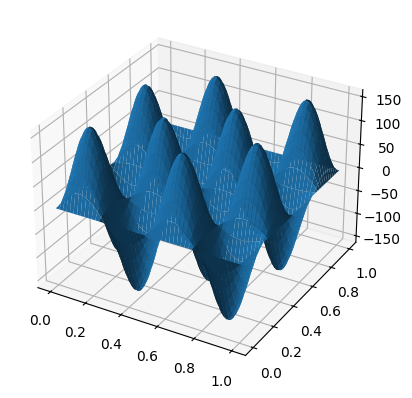

In [9]:
# plot of the right hand side of the helmholtz equation
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()

In [10]:
def exact_solution(x, y):
    return torch.sin(K0 * x) * torch.sin(K0 * y)

In [11]:
z = exact_solution(x, y)

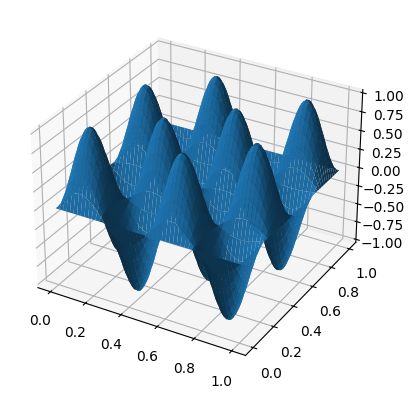

In [12]:
# plot of the exact solution to the helmholtz equation
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()

In [100]:
# Function to compute second derivative using PyTorch autograd
def second_derivative_x(network, x, y):
    x = x.requires_grad_(True)
    u = network(x, y)
    # First derivative
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Second derivative
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    return u_xx

def second_derivative_y(network, x, y):
    y = y.requires_grad_(True)
    u = network(x, y)
    # First derivative
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Second derivative
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    return u_yy

# The PDE residuum function
def pde_residuum(network, x, y):
    u_xx = second_derivative_x(network, x, y)
    u_yy = second_derivative_y(network, x, y)
    u = network(x, y)
    return rhs_function(x, y) + K0**2 * u + u_yy + u_xx

In [101]:
pde_residuum(pinn, torch.rand(2, 1), torch.rand(2, 1))

tensor([[ 0.2576],
        [-0.2760]], grad_fn=<AddBackward0>)

In [103]:
x_ = torch.rand(2, 1)
y_ = torch.rand(2, 1)
res = pde_residuum(pinn, x_, y_)
res = res.requires_grad_(True)
grad_res = torch.autograd.grad(res, x_, grad_outputs=torch.ones_like(res), create_graph=True)[0]

In [104]:
grad_res

tensor([[-20.2578],
        [ 17.3556]], grad_fn=<AddBackward0>)

In [105]:
def grad(u, x):
    # compute gradient of u wrt. to x 
    return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

In [106]:
x_ = torch.rand(2, requires_grad=True)
u = 2 * x_**2 + 10
grad(u, x_)

tensor([2.3471, 2.8155], grad_fn=<MulBackward0>)

In [107]:
minval = 0.0 + 0.001
maxval = 1.0 - 0.001
collocation_points_x = (minval - maxval) * torch.rand(N_COLLOCATION_POINTS, 1) + maxval
collocation_points_y = (minval - maxval) * torch.rand(N_COLLOCATION_POINTS, 1) + maxval

def loss_fn(network, bc_loc, bc_val):
    pde_res = pde_residuum(network, collocation_points_x, collocation_points_y)
    pde_loss = torch.mean(pde_res**2)
    
    # gradient of pde_res with respect to collocation points
    grad_pde_res_x = torch.autograd.grad(pde_res, collocation_points_x, grad_outputs=torch.ones_like(pde_res), create_graph=True)[0]
    grad_pde_res_y = torch.autograd.grad(pde_res, collocation_points_y, grad_outputs=torch.ones_like(pde_res), create_graph=True)[0]
    grad_pde_loss = 0.5 * torch.mean(grad_pde_res_x**2) + 0.5 * torch.mean(grad_pde_res_y**2)

    # boundary conditions
    bc_residuum_contribution = 0
    for i, bc in enumerate(bc_loc):
        x, y = bc
        bc_residuum = network(x, y) - bc_val[i]
        bc_residuum_contribution += torch.mean(bc_residuum**2)

    return pde_loss + grad_pde_loss + BC_LOSS_WEIGHT * bc_residuum_contribution

In [108]:
free_var = torch.linspace(0, 1, 100).unsqueeze(1)
fixed_0 = torch.zeros(100, 1)
fixed_1 = torch.ones(100, 1)
bc_loc = [
    (free_var, fixed_0),
    (free_var, fixed_1),
    (fixed_0, free_var),
    (fixed_1, free_var)
]

dirichlet_val = torch.zeros(100, 1)
bc_val = [
    dirichlet_val,
    dirichlet_val,
    dirichlet_val,
    dirichlet_val
]

In [109]:
loss_fn(pinn, bc_loc, bc_val)

tensor(528900.8125, grad_fn=<AddBackward0>)

In [110]:
pinn = MLP([2, 150, 150, 150, 1], torch.sin)

In [111]:
loss_hist = []

In [119]:
optimizer = optim.Adam(pinn.parameters(), lr=LEARNING_RATE)
epochs = N_OPTIMIZATION_EPOCHS

# Training loop
for epoch in range(1,epochs+1):
    # Forward pass
    loss = loss_fn(pinn, bc_loc, bc_val)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    if epoch % 100 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.8f}')
        loss_hist.append(loss.item())

Epoch [1/1000], Loss: 2391.54150391
Epoch [100/1000], Loss: 2112.15014648
Epoch [200/1000], Loss: 1729.59167480
Epoch [300/1000], Loss: 1650.19323730
Epoch [400/1000], Loss: 1278.11523438
Epoch [500/1000], Loss: 9658.66894531
Epoch [600/1000], Loss: 1011.16284180
Epoch [700/1000], Loss: 900.00952148
Epoch [800/1000], Loss: 930.58752441
Epoch [900/1000], Loss: 722.07702637
Epoch [1000/1000], Loss: 642.09790039


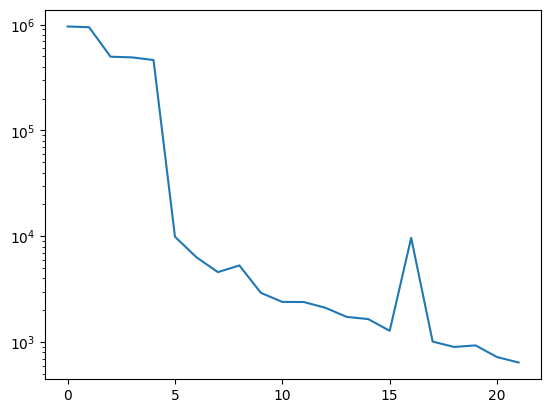

In [120]:
plt.plot(loss_hist)
plt.yscale("log")

In [121]:
# generation of 2d grid
xs = torch.linspace(0, 1, steps=DOF_X)
ys = torch.linspace(0, 1, steps=DOF_Y)
x, y = torch.meshgrid(xs, ys, indexing='xy')

In [122]:
z = pinn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1))

In [123]:
z1 = exact_solution(x, y)

In [124]:
torch.mean(z.reshape(100, 100) - z1) # mean absolute difference

tensor(0.0070, grad_fn=<MeanBackward0>)

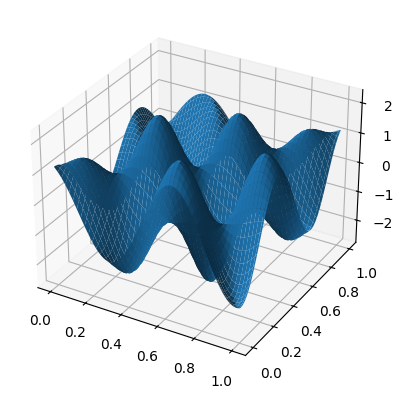

In [125]:
# plot of the predicted solution to the helmholtz equation
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.reshape(100, 100).detach().numpy())
plt.show()